Построить классификатор изображений: определение модели автомобиля по фото.  

In [1]:
!nvidia-smi

Thu May 27 09:42:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import csv
import sys
import os

from ImageDataAugmentor.image_data_augmentor import *
import albumentations

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
# #увеличим дефолтный размер графиков
# from pylab import rcParams
# rcParams['figure.figsize'] = 10, 5
# #графики в svg выглядят более четкими
# %config InlineBackend.figure_format = 'svg' 
# %matplotlib inline

In [46]:
# ! pip install git+https://github.com/mjkvaak/ImageDataAugmentor.git@ce9bf4d7d532bfcb14fda7fb43d7bcdc6d7990ff

  Cloning https://github.com/mjkvaak/ImageDataAugmentor.git (to revision ce9bf4d7d532bfcb14fda7fb43d7bcdc6d7990ff) to /tmp/pip-req-build-bgnhu6jb
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor.git /tmp/pip-req-build-bgnhu6jb
  Running command git rev-parse -q --verify 'sha^ce9bf4d7d532bfcb14fda7fb43d7bcdc6d7990ff'
  Running command git fetch -q https://github.com/mjkvaak/ImageDataAugmentor.git ce9bf4d7d532bfcb14fda7fb43d7bcdc6d7990ff
  Running command git checkout -q ce9bf4d7d532bfcb14fda7fb43d7bcdc6d7990ff
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=28027 sha256=fe56a05dca21a18f2933ee65896033f925c3b4edf369c97441121a786750caee
  Stored in directory: /root/.cache/pip/wheels/87/56/68/e54fc560550bd966481b2974726ad328220a9a1cff91c81e49
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [57]:
# В setup выносим основные настройки

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 64
LR                   = 1e-4
VAL_SPLIT            = 0.15 # выделяем на тест

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

RANDOM_SEED=42
DATA_PATH = '../input/sfcarclassif/'
PATH = "../working/car/" # рабочая директория

## EDA / Анализ данных

In [23]:
train_df = pd.read_csv(DATA_PATH+'train.csv')
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [26]:
# распределение классов
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

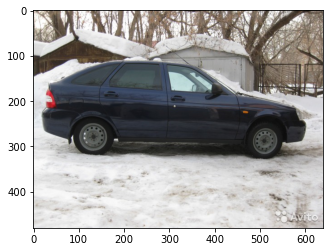

(640, 480)

In [42]:
image = PIL.Image.open(DATA_PATH+'train/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

## Подготовка данных
Аугментация данных

In [71]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

In [72]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=DATA_PATH+'test/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
# train the model with real-time data augmentations
model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=50,
        validation_data=validation_generator,
        validation_steps=len(validation_generator))

# Модель

In [73]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83689472/83683744 [==============================] - 2s 0us/step


In [74]:
print(len(base_model.layers))

132


In [75]:
base_model.summary()
# Рекомендация: Попробуйте и другие архитектуры сетей

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [76]:
# Устанавливаем новую "голову" (head)

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [77]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [78]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

# Рекомендация 1. Добавьте другие функции из https://keras.io/callbacks/
# Рекомендация 2. Используйте разные техники управления Learning Rate
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng)
# http://teleported.in/posts/cyclic-learning-rate/ (eng)

In [79]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

# Рекомендация: попробуйте применить transfer learning с fine-tuning

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
207/207 [==============================] - 364s 2s/step - loss: 1.8488 - accuracy: 0.3960 - val_loss: 0.9338 - val_accuracy: 0.7574

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
207/207 [==============================] - 203s 978ms/step - loss: 0.4686 - accuracy: 0.8290 - val_loss: 0.4062 - val_accuracy: 0.8733

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
207/207 [==============================] - 202s 973ms/step - loss: 0.2713 - accuracy: 0.9008 - val_loss: 0.3335 - val_accuracy: 0.8875

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
207/207 [==============================] - 202s 971ms/step - loss: 0.1953 - accuracy: 0.9320 - val_loss: 0.2996 - val_accuracy: 0.9017

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
207/207 [==============================] - 201s 967ms/step - loss: 0.1546 - accuracy: 0.9435 - val_loss: 0.2761 - val_accuracy: 0.9073

Epoch 00005: saving model to best_model.hdf5


In [80]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [81]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


37/37 [==============================] - 24s 646ms/step - loss: 0.2842 - accuracy: 0.9055
Accuracy: 90.55%


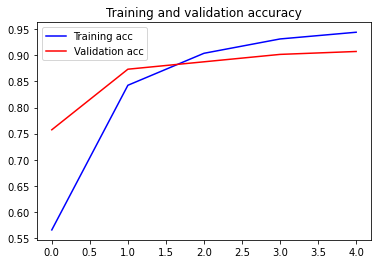

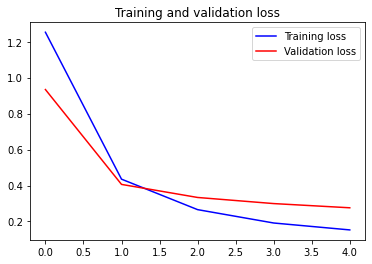

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Предсказание на тестовых данных

In [84]:
test_sub_generator.samples

6675

In [85]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


105/105 [==============================] - 117s 1s/step


In [87]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [88]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7
